In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image

import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from caps_model import CapsuleNetwork, CapsuleLoss, display_images
from caps_utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset

In [2]:
BASE_DIR = "D:/YOLO_Caps"
seed = 41
batch_size = 16
classes = ["cropped_nodule", "cropped_non_nodule"]
train_ratio = 0.8
image_size = 128
scenario = 1
data_augmentation = False

In [3]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

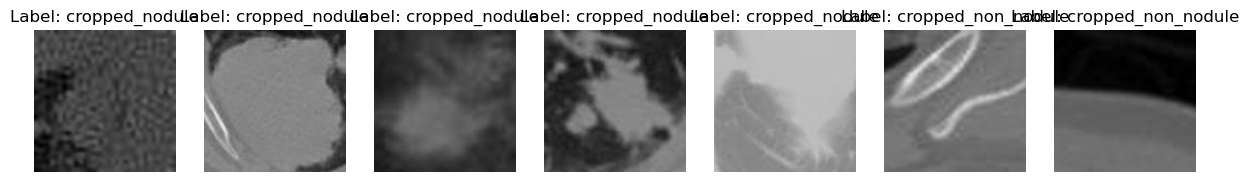

In [4]:
train_transforms = None

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

if data_augmentation:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
        transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                        scale=(0.8, 1.2),  # Scale for zoom in/out
                        ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
        transform
    ])
else: 
    train_transforms = transform

dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "cropped_nodule"))), classes=classes, scenario=scenario)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
dataset.visualize_images(num_images=7)

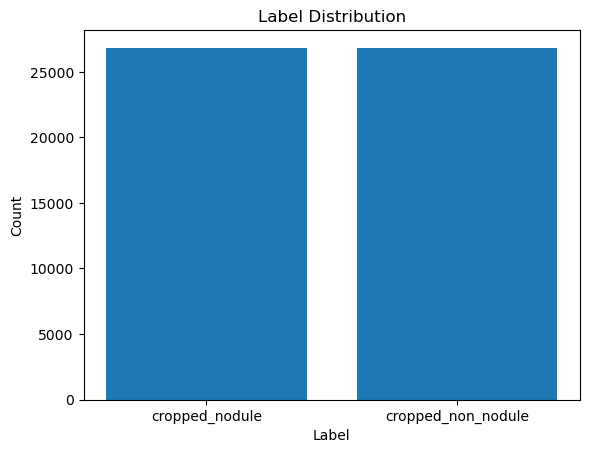

In [5]:
dataset.display_label_distribution()

Train size: 42950 --- Test size: 5369 --- Val size: 5369


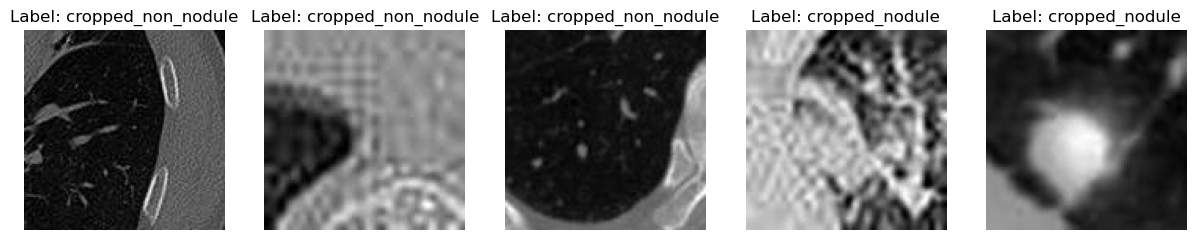

In [6]:
train_size = int(train_ratio * len(dataset))
testval_size = len(dataset) - train_size
test_size = int(testval_size*0.5)
val_size = int(testval_size*0.5)

print(f"Train size: {train_size} --- Test size: {test_size} --- Val size: {val_size}")
train_dataset, testval_dataset = random_split(dataset, [train_size, testval_size])
test_dataset, val_dataset = random_split(testval_dataset, [test_size, val_size])

train_dataset = TransformDataset(train_dataset, transform=train_transforms)
val_dataset = TransformDataset(val_dataset, transform=train_transforms)
test_dataset = TransformDataset(test_dataset, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(train_loader, classes)

In [7]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

# Initialize early stopping
early_stopping = EarlyStopping(patience=10)

In [9]:
n_epochs = 20
losses = capsule_net.train_model(train_loader, val_loader, criterion, optimizer, n_epochs, early_stopping, print_every=1)

Train Loss so far: 0.0056 | Train Accuracy: 40.62%
Train Loss so far: 0.0090 | Train Accuracy: 39.58%
Train Loss so far: 0.0121 | Train Accuracy: 39.06%
Train Loss so far: 0.0150 | Train Accuracy: 42.50%
Train Loss so far: 0.0180 | Train Accuracy: 40.62%
Train Loss so far: 0.0211 | Train Accuracy: 43.75%
Train Loss so far: 0.0242 | Train Accuracy: 44.53%


KeyboardInterrupt: 